# Replication Code for Wu and Resnick (2021):

In [ ]:
import time
import re
import csv
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys as sys
import logging
from datetime import datetime, timedelta, date

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, unquote

from youtubesearchpython import ChannelsSearch
from googleapiclient.discovery import build

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC



In [ ]:
# Logging Setup

LOG_LEVEL = logging.INFO          
LOG_FILE  = "crawl.log"           
PRINT_EVERY_VIDEOS = 5            

logger = logging.getLogger("ytcrawl")
logger.setLevel(LOG_LEVEL)
fmt = logging.Formatter("[%(asctime)s] %(levelname)s: %(message)s", "%H:%M:%S")
sh = logging.StreamHandler(sys.stdout); sh.setFormatter(fmt); sh.setLevel(LOG_LEVEL)
logger.handlers.clear(); logger.addHandler(sh)
if LOG_FILE:
    fh = logging.FileHandler(LOG_FILE); fh.setFormatter(fmt); fh.setLevel(logging.DEBUG)
    logger.addHandler(fh)


In [ ]:
# Scrape media outlets from mediabiasfactcheck.com 

# CONFIG
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}
video_keywords = ['video', 'mediathek', 'tv', 'broadcast', 'media', 'sendung', 'youtube', 'film', 'player', 'livestream']
MAX_SUBPAGES = 10

def setup_driver():
    options = Options()
    options.headless = True
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    return webdriver.Chrome(options=options)

def get_media_outlets_with_leaning(driver):
    url = "https://mediabiasfactcheck.com/filtered-search/?country=DE"
    driver.get(url)
    time.sleep(3)
    results = []

    try:
        table = driver.find_element(By.ID, "mbfc-table")
        rows = table.find_elements(By.TAG_NAME, "tr")[1:]  # skip header
        for row in rows:
            cells = row.find_elements(By.TAG_NAME, "td")
            if len(cells) >= 2:
                name = cells[0].text.strip()
                leaning = cells[1].text.strip()
                results.append([name, leaning])
    except Exception as e:
        print(f"Could not parse MBFC table: {e}")
    return results

def main():
    driver = setup_driver()
    try:
        outlets = get_media_outlets_with_leaning(driver)
        print(f"✅ Found {len(outlets)} German media outlets.")

        # Export to CSV
        with open("german_outlets_political_leaning.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Name", "Political Leaning"])
            writer.writerows(outlets)

        print("\n✅ Exported to 'german_outlets_political_leaning.csv'.")

    finally:
        driver.quit()

if __name__ == "__main__":
    main()

✅ Found 74 German media outlets.

✅ Exported to 'german_outlets_political_leaning.csv'.


In [22]:
german_outlets=pd.read_csv("data/german_outlets_political_leaning.csv")

In [ ]:
# Retrieving YouTube channel information of these media outlets

unique_outlets = german_outlets.drop_duplicates(subset="Name").reset_index(drop=True)

channel_results = []

for _, row in tqdm(unique_outlets.iterrows(), total=len(unique_outlets)):
    outlet_name = row["Name"]
    political_leaning = row.get("Political Leaning", None)

    try:
        search = ChannelsSearch(outlet_name, limit=1)
        data = search.result()

        if data["result"]:
            channel = data["result"][0]
            channel_results.append({
                "Name": outlet_name,
                "Political Leaning": political_leaning,
                "Channel Name": channel["title"],
                "Channel Link": channel["link"],
                "Subscribers": channel.get("subscribers", "N/A"),
                "Verified": channel.get("verified", False)
            })
        else:
            channel_results.append({
                "Name": outlet_name,
                "Political Leaning": political_leaning,
                "Channel Name": None,
                "Channel Link": None,
                "Subscribers": None,
                "Verified": None
            })

    except Exception as e:
        channel_results.append({
            "Name": outlet_name,
            "Political Leaning": political_leaning,
            "Channel Name": None,
            "Channel Link": None,
            "Subscribers": None,
            "Verified": None,
            "Error": str(e)
        })


channel_df = pd.DataFrame(channel_results)

final_df.to_csv("german_outlets_youtube_channels.csv", index=False)
print(channel_df.head())


100%|██████████| 74/74 [00:52<00:00,  1.42it/s]

               Name         Political Leaning      Channel Name  \
0       Apollo News                     Right       Apollo News   
1         Apost.com  Conspiracy-Pseudoscience   Post RT Clarity   
2            ARD.de              Least Biased        tagesschau   
3    Belltower.News               Left-Center    Belltower News   
4  Berliner Zeitung               Left-Center  Berliner Zeitung   

                                        Channel Link           Subscribers  \
0  https://www.youtube.com/channel/UCR_iFmLcHBFxc...        @apollonewsnet   
1  https://www.youtube.com/channel/UCPcZgsAhR46iO...        @PostRTClarity   
2  https://www.youtube.com/channel/UC5NOEUbkLheQc...           @tagesschau   
3  https://www.youtube.com/channel/UCS3YexlWX7c0B...       @NetzGegenNazis   
4  https://www.youtube.com/channel/UCOK_An4e3Um5p...  @BerlinerZeitung_BLZ   

  Verified  
0    False  
1    False  
2    False  
3    False  
4    False  


In [ ]:
# Hard-coding/manually adjusting/removing some handles

channel_df.loc[channel_df["Name"]=="Apost.com", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="Euro|Topics", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="Global Ideas Center", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="SpringerLink", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="NeuroNation", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="Real News 24", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="Pfalzischer Merkur", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="The Local (Germany)", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="Homeopathy Journal", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="True Activist", "Subscribers"]=pd.NA
channel_df.loc[channel_df["Name"]=="WEB.DE", "Subscribers"]=pd.NA

channel_df.loc[channel_df["Name"]=="ARD.de", "Subscribers"]="@ARD"
channel_df.loc[channel_df["Name"]=="Bundeszentrale für Politische Bildung (BPB)", "Subscribers"]="@bpb_de"
channel_df.loc[channel_df["Name"]=="Express.de", "Subscribers"]="@EXPRESSKoeln"
channel_df.loc[channel_df["Name"]=="Munchner Merkur", "Subscribers"]="@merkuronline"
channel_df.loc[channel_df["Name"]=="Neues Deutschland", "Subscribers"]="@ndaktuell"
channel_df.loc[channel_df["Name"]=="NordKurier", "Subscribers"]="@NordkurierTV"
channel_df.loc[channel_df["Name"]=="N-tv", "Subscribers"]="@n-tv"
channel_df.loc[channel_df["Name"]=="Saarbrucker Zeitung", "Subscribers"]="@SaarbrueckerZeitung"
channel_df.loc[channel_df["Name"]=="TAG24", "Subscribers"]="@TAG24DE"
channel_df.loc[channel_df["Name"]=="The Postillion", "Subscribers"]="@Der_Postillon"

In [105]:
channel_df=channel_df[channel_df["Subscribers"].notna()]


In [ ]:
# Adding some channels manually

## Left channels (as identified by https://www.rosalux.de/fileadmin/rls_uploads/pdfs/Studien/Studien_7-19_Influencer_innen_web.pdf)

left_links = [
    "https://www.youtube.com/@RaykAnders",
    "https://www.youtube.com/@MarieBauer",
    "https://www.youtube.com/@Weckerswelt",
    "https://www.youtube.com/@neumeiermoritz",
    "https://www.youtube.com/@Filmpiraten",
    "https://www.youtube.com/@leftvision",
    "https://www.youtube.com/@acTVismMunich",
    "https://www.youtube.com/@linksfraktion",
    "https://www.youtube.com/@nachdenkseiten745",
    "https://www.youtube.com/@weltnetzTV",
    "https://www.youtube.com/@Schlumpf"
]

right_links=[
## Right channels
## (as identified by https://machine-vs-rage.net/ausgabe-6/subscribe-to-subversion/)
    "https://www.youtube.com/@roger.beckamp",
    "https://www.youtube.com/@Stuerzenberger-Michael",
    "https://www.youtube.com/@JNDeutschland",
    "https://www.youtube.com/@jungetat",
    "https://www.youtube.com/@Junge_Freiheit",

## (as identified by https://correctiv.org/aktuelles/neue-rechte/2024/08/19/rechte-influencer-auf-youtube-welche-werbung-ideologische-botschaften-finanziert/)
    "https://www.youtube.com/@symmetriebrecher",
    "https://www.youtube.com/@JasminKosubekOriginal",
    "https://www.youtube.com/@Clownswelt",
    "https://www.youtube.com/@eingollan",
    "https://www.youtube.com/@BorisvonMorgenstern",
    "https://www.youtube.com/@DerMedienfuzzi",

## (as identified by https://www.belltower.news/rechte-youtube-landschaft-rechtsextreme-influencerinnen-82747/)
    "https://www.youtube.com/@patrickschroder9077",
    "https://www.youtube.com/@frankkraemer",

## (additionally:)
    "https://www.youtube.com/@Krautzone"]


In [108]:
# Function to extract handle from link
def extract_handle(link):
    return link.split("@")[-1].strip("/")

# Create list of dicts for new channels
new_channels = []

for link in left_links:
    new_channels.append({
        "Name": None,
        "Political Leaning": "left",
        "Channel Name": None,
        "Channel Link": link,
        "Subscribers": f"@{extract_handle(link)}",
        "verified": None
    })

for link in right_links:
    new_channels.append({
        "Name": None,
        "Political Leaning": "right",
        "Channel Name": None,
        "Channel Link": link,
        "Subscribers": f"@{extract_handle(link)}",
        "verified": None
    })

# Create a DataFrame from new channels
new_df = pd.DataFrame(new_channels)

# Append to the original channel_df
channel_df = pd.concat([channel_df, new_df], ignore_index=True)

channel_df = channel_df.drop_duplicates(subset='Subscribers', keep='first')

In [ ]:
# Extracting and loading API Key
with open('api_key.txt', 'r') as file:
    api_key = file.readline().strip()

api_key

In [ ]:
# Getting channel info from API using handles

def get_channel_info_forhandle(handle, api_key):
    handle_clean = handle.strip().lstrip("@")
    
    url = 'https://www.googleapis.com/youtube/v3/channels'
    params = {
        'part': 'snippet,statistics',
        'forHandle': handle_clean,
        'key': api_key
    }

    response = requests.get(url, params=params).json()

    if 'error' in response:
        print(f"[API ERROR] {handle}: {response['error']}")
        return None

    items = response.get('items', [])
    if not items:
        print(f"[NOT FOUND] {handle}")
        return None

    info = items[0]
    return {
        'Subscribers': handle,
        'channel_id': info['id'],
        'title': info['snippet']['title'],
        'description': info['snippet'].get('description'),
        'subscriber_count': info['statistics'].get('subscriberCount'),
        'view_count': info['statistics'].get('viewCount'),
        'video_count': info['statistics'].get('videoCount'),
        'language': info['snippet'].get('defaultLanguage') or info['snippet'].get('defaultAudioLanguage'),
        'country': info['snippet'].get('country')
    }

channel_data = []
for handle in channel_df['Subscribers']:
    print(f"Processing {handle}...")
    info = get_channel_info_forhandle(handle, api_key)
    if info:
        channel_data.append(info)
    else:
        channel_data.append({
            'Subscribers': handle,
            'channel_id': None,
            'title': None,
            'description': None,
            'subscriber_count': None,
            'view_count': None,
            'video_count': None
        })
    time.sleep(1)


#Combine into a new DataFrame
api_df = pd.DataFrame(channel_data)
df_final = channel_df.merge(api_df, on='Subscribers', how='left')
df_final.to_csv("data/youtube_channel_info.csv", index=False)


Processing @apollonewsnet...
Processing @ARD...
Processing @NetzGegenNazis...
Processing @BerlinerZeitung_BLZ...
Processing @bild...
Processing @bpb_de...
Processing @CicerOnline...
Processing @climateactiontracker...
Processing @climatecosmos-com...
Processing @COMPACTTV...
Processing @DeutschlandDe1...
Processing @dradiowissen...
Processing @disclosetv...
Processing @dpa_com...
Processing @dwnews...
Processing @europeancouncilonforeignre6395...
Processing @EikeClimateEnergy2...
Processing @EXPRESSKoeln...
Processing @FairPlanet...
Processing @faz...
Processing @frankfurterrundschau...
Processing @fiejournal...
Processing @frontiersctsi7926...
Processing @FrontiersInCFD...
Processing @GeneralAnzeiger...
Processing @handelsblattvideo...
Processing @KielInstitute...
Processing @bneIntelliNews...
Processing @journalistenwatch4462...
Processing @jungeWeltTV...
Processing @merkuronline...
Processing @berliner-morgenpost...
Processing @n-tv...
Processing @ndaktuell...
Processing @newsde...


In [33]:
df_final=pd.read_csv("data/youtube_channel_info.csv")
df_final=df_final[["channel_id", "title", "description", "subscriber_count", "view_count", "video_count", "Political Leaning","language", "country"]]
df_final.rename(columns={"Political Leaning":"leaning"}, inplace=True)

In [ ]:
# Concatenating Peer Saleth's channels
channels_saleth=pd.read_csv("data/youtube/channels.csv")
channels_saleth=channels_saleth[["id", "leaning", "title", "description", "subscriber_count", "view_count", "video_count"]]
channels_saleth.rename(columns={"id":"channel_id"}, inplace=True)
channels_saleth["language"]="de"
channels_saleth["country"]="DE"
channels_saleth=channels_saleth[df_final.columns]

In [36]:
channels_df=pd.concat([df_final, channels_saleth], ignore_index=True).drop_duplicates(subset="channel_id", keep="first")

In [41]:
channels_df["leaning"]=channels_df["leaning"].replace({"Right":"right",
                                                       "Left":"left",
                                                       "Left-Center":"left-center",
                                                       "Right-Center":"right-center",
                                                       # Conspiracy-Pseudoscience (Compact-TV and Journalistenwatch) and Questionable Sources (Disclose.tv and Syriana Analysis)
                                                       #  are coded as right leaning
                                                       "Conspiracy-Pseudoscience": "right",
                                                       "Questionable Sources":"right",
                                                       "Least Biased":"news/science",
                                                       "Pro-Science":"news/science"})

# Re-setting "middle" leaning of Saleth channels
channels_df.loc[channels_df['title'] == 'CDU', 'leaning'] = 'right-center'
channels_df.loc[channels_df['title'] == 'BÜNDNIS 90/DIE GRÜNEN', 'leaning'] = 'left-center'
channels_df.loc[channels_df['title'] == 'SPD', 'leaning'] = 'left-center'

channels_df = channels_df[channels_df['leaning'] != 'Satire']


In [43]:
channels_df.head()

,channel_id,title,description,subscriber_count,view_count,video_count,leaning,language,country
0,UCR_iFmLcHBFxc3x3CA71xvw,Apollo News,Das Magazin für die Freiheit.\n\nhttp://apollo...,161000,22372128,235,right,NaN,DE
1,UCqmQ1b96-PNH4coqgHTuTlA,ARD,"Keine Ahnung, was die ARD Mediathek zu bieten ...",864000,259984854,2996,news/science,NaN,DE
2,UCS3YexlWX7c0BxBHOHYtAbw,Belltower News,Belltower.News ist ein Internetportal gegen Re...,1620,1452478,78,left-center,NaN,NaN
3,UCOK_An4e3Um5pkziO3e1Qyw,Berliner Zeitung,Unabhängige Nachrichten und Hintergründe aus B...,13300,4560366,201,left-center,NaN,DE
4,UC4zcMHyrT_xyWlgy5WGpFFQ,BILD,BILD BLEIBT BILD.\n\nAXEL SPRINGER DEUTSCHLAND...,1730000,3265348017,32825,right-center,NaN,DE


In [ ]:
# Scrape featured channels 

# Set up Selenium
options = Options()
options.add_argument("--window-size=1920,1080")
options.add_argument("user-agent=Mozilla/5.0")
driver = webdriver.Chrome(options=options)

# Define function to handle cookie consent
def accept_youtube_consent(driver):
    try:
        consent_button = WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((
                By.XPATH,
                "//button[contains(text(), 'Alle akzeptieren')] | //button[contains(text(), 'Accept all')]"
            ))
        )
        consent_button.click()
        print("✅ Accepted cookie consent.")
        time.sleep(2)
    except Exception:
        print("ℹ️ No cookie banner found.")

# Visit homepage to trigger cookie banner (once per session)
driver.get("https://www.youtube.com/")
accept_youtube_consent(driver)
time.sleep(3)

featured_channels = []

# Loop over seed channels 
for _, row in tqdm(channels_df.iterrows(), total=len(channels_df)):
    channel_id = row['channel_id']
    leaning = row['leaning']
    url = f"https://www.youtube.com/channel/{channel_id}/channels"

    driver.get(url)
    time.sleep(3)

    # Scroll to trigger lazy loading
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)

    elems = driver.find_elements(By.XPATH, '//*[@id="channel-info"]')
    for el in elems:
        href = el.get_attribute("href")
        if href and "/@" in href:
            handle = unquote(href.split("/@")[-1])
            featured_channels.append({
                'channel_handle': handle,
                'parent_id': channel_id,
                'political_leaning': leaning
            })

driver.quit()

# Create DataFrame
df_featured = pd.DataFrame(featured_channels).drop_duplicates(subset='channel_handle')
df_featured.to_csv("data/featured_channels.csv")



ℹ️ No cookie banner found.


100%|██████████| 106/106 [11:12<00:00,  6.35s/it]


In [46]:
df_featured=pd.read_csv("data/featured_channels.csv")

In [47]:
df_featured = df_featured.merge(
    channels_df[['channel_id', 'title']],
    how='left',
    left_on='parent_id',
    right_on='channel_id'
).rename(columns={'title': 'parent_title'})


In [48]:
channels_df["parent_id"] = None

C:\Users\jonas\AppData\Local\Temp\ipykernel_19944\2156276885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channels_df["parent_id"] = None


In [49]:
# Prepare featured channels for merging
df_featured_clean = df_featured.rename(columns={
    "channel_handle": "channel_id",  # placeholder, will resolve later
    "political_leaning": "leaning"
})

# Add missing columns for now with None
for col in ["title", "description", "subscriber_count", "view_count", "video_count", "language", "country"]:
    df_featured_clean[col] = None

# Reorder columns to match
df_featured_clean = df_featured_clean[channels_df.columns]

In [50]:
df_featured_clean = df_featured_clean.loc[:, ~df_featured_clean.columns.duplicated()]

In [51]:
channels_df_combined = pd.concat([channels_df, df_featured_clean], ignore_index=True)

In [ ]:
# Retrieve channel information for featured channels
youtube = build('youtube', 'v3', developerKey=api_key)

# Make a copy to avoid changing the original
df_all = channels_df_combined.copy()

# FILTER: rows needing enrichment (likely scraped featured channels) 
to_resolve = df_all[df_all['title'].isnull() & ~df_all['channel_id'].str.startswith("UC")].copy()

# API: Resolve each handle individually
resolved_rows = []

for handle in to_resolve['channel_id'].unique():
    try:
        request = youtube.channels().list(
            part="id,snippet,statistics",
            forHandle=f"@{handle}"
        )
        response = request.execute()
        items = response.get("items", [])
        if items:
            item = items[0]
            resolved_rows.append({
                'channel_id_resolved': item['id'],  # UC...
                'handle': handle,
                'title_resolved': item['snippet'].get('title'),
                'description_resolved': item['snippet'].get('description'),
                'subscriber_count_resolved': int(item['statistics'].get('subscriberCount', 0)),
                'view_count_resolved': int(item['statistics'].get('viewCount', 0)),
                'video_count_resolved': int(item['statistics'].get('videoCount', 0)),
                'language_resolved': item['snippet'].get('defaultLanguage') or item['snippet'].get('defaultAudioLanguage'),
                'country_resolved': item['snippet'].get('country')
            })
    except Exception as e:
        print(f"❌ Failed to resolve @{handle}: {e}")

# Wrap resolved results into a DataFrame 
df_resolved = pd.DataFrame(resolved_rows)

#  MERGE: Combine with original data
df_merged = df_all.merge(
    df_resolved,
    how='left',
    left_on='channel_id',
    right_on='handle',
    suffixes=('', '_resolved')
)

# Apply resolved metadata where available
df_merged['channel_id'] = df_merged['channel_id_resolved'].combine_first(df_merged['channel_id'])
df_merged['title'] = df_merged['title_resolved'].combine_first(df_merged['title'])
df_merged['description'] = df_merged['description_resolved'].combine_first(df_merged['description'])
df_merged['subscriber_count'] = df_merged['subscriber_count_resolved'].combine_first(df_merged['subscriber_count'])
df_merged['view_count'] = df_merged['view_count_resolved'].combine_first(df_merged['view_count'])
df_merged['video_count'] = df_merged['video_count_resolved'].combine_first(df_merged['video_count'])
df_merged['language'] = df_merged['language_resolved'].combine_first(df_merged.get('language'))
df_merged['country'] = df_merged['country_resolved'].combine_first(df_merged.get('country'))


# Which rows were successfully resolved
df_merged['resolved'] = df_merged['channel_id_resolved'].notnull()

# CLEANUP: Remove temporary columns 
df_final = df_merged.drop(columns=[
    col for col in df_merged.columns if col.endswith('_resolved') or col == 'handle'
])



In [ ]:
df_final=df_final[(df_final["country"]=="DE")|(df_final["country"].isna())]
df_final=df_final[(df_final["language"]=="de")|(df_final["language"].isna())]

# International Audience/Non-German scope
df_final=df_final[~df_final['title'].isin(["BILD Lagezentrum International",
                                           "BILD на русском",
                                           "Climate Action Tracker",
                                           "Climate Cosmos",
                                           # Cross Point (Excemption, primarily turns to the murder of Oury Jalloh, German scope)
                                           "DEUTSCHLAND.de",
                                           "Deutsch lernen mit der DW",
                                           "DW Documentary",
                                           "DW Español",
                                           "DW News",
                                           "DW Planet A",
                                           "DW Podcasts",
                                           "European Council on Foreign Relations (ECFR) - Warsaw Office",
                                           "European Institute for Climate and Energy EIKE",
                                           "FairPlanet TV",
                                           "Frontiers in Energy",
                                           "GermanyDiplo",
                                           "Global Solutions Initiative Foundation",
                                           "Goethe-Institut",
                                           "Kiel Institute for the World Economy",
                                           "ResearchGate",
                                           "Scope Group",
                                           "Statista",
                                           "Study in Germany",
                                           "Syriana Analysis",
                                           "The Mosireen Collective",
                                           "videoccupy türkiye",
                                           "aWish",
                                           "bne IntelliNews ",
                                           "ReelNews",
                                           # Throwing out old accounts by German influencer "Rezo", 
                                           # his currently active channel, "Schlumpf" where he uploads streams commenting on contemporary political and pop-cultural phenomena is retained.
                                           "Renzo",
                                           "Rezo ja lol ey", 
                                           "rezo"
                                           ])]

# Removing overly topic-specific channels (sports, health, gaming, entertainment only) and research instiutes with low discussion output.
# Pop-cultural news, comedy, and satire formats are explicitly retained.
df_final=df_final[~df_final['title'].isin(["ARD GESUND mit Dr. Julia Fischer",
                                           "Bares für Rares",
                                           "Christian-Albrechts-Universität zu Kiel",
                                           "Game Two",
                                           "Leibniz- Gemeinschaft",
                                           "PS - Automagazin",
                                           "Phrasenmäher",
                                           "RP ONLINE – GESUNDHEIT & LIFESTYLE",
                                           "RP ONLINE – WIR SIND SPORT",
                                            "Rheinische Post - Corporate Content",
                                            "SPORT BILD",
                                            "VOX",
                                            "ZBW - Leibniz-Informationszentrum Wirtschaft",
                                            "ZDFbesseresser",
                                            "sportstudio",
                                            "sportstudio fußball",
                                            "RTL+"
                                           ])]

# Removing regional party  offices
df_final=df_final[~df_final['title'].isin(["SPD Berlin",
                                           "SPD Landtagsfraktion NRW",
                                           "SPD Niedersachsen",
                                           "SPD Rheinland-Pfalz",
                                           "SPD Sachsen-Anhalt"])]


# Adding more relevant outlets
# API setup
youtube = build('youtube', 'v3', developerKey=api_key)

# Define known party handles and metadata
addition = [
    # Bundestag
    {"handle": "cducsu", "leaning": "right-center"},
    {"handle": "gruenebundestag", "leaning": "left-center"},
    {"handle": "AfDFraktionimBundestag", "leaning": "right"},

    # Youth Organizations
    {"handle": "jungeunion", "leaning": "right-center"},
    {"handle": "jusos", "leaning": "left"},
    {"handle": "JATVKanal", "leaning": "right"},
    {"handle": "GrueneJugend", "leaning": "left"},
    {"handle": "linksjugendsolid", "leaning": "left"},

    # Public Broadcasting
    {"handle": "bayerischerrundfunk", "leaning": "news/science"},
    {"handle": "hessischerRundfunkARD", "leaning": "news/science"},
    {"handle": "mdr", "leaning": "news/science"},
    {"handle": "rbb", "leaning": "news/science"},
    {"handle": "saarlaendischerrundfunk", "leaning": "news/science"},
    {"handle": "ZDFDoku", "leaning": "news/science"},
    {"handle": "artede", "leaning": "news/science"},

    # Other relevant news outlets
    {"handle": "WELTVideoTV", "leaning": "right-center"},
    {"handle": "sternTV", "leaning": "left-center"},
    {"handle": "Simplicissimus", "leaning": "left-center"}
]

# Collect resolved data
party_channels = []

for entry in addition:
    handle = entry["handle"]
    try:
        request = youtube.channels().list(
            part="id,snippet,statistics",
            forHandle=f"@{handle}"
        )
        response = request.execute()
        items = response.get("items", [])
        if items:
            item = items[0]
            party_channels.append({
                'channel_id': item['id'],  # UC...
                'title': item['snippet'].get('title'),
                'description': item['snippet'].get('description'),
                'subscriber_count': int(item['statistics'].get('subscriberCount', 0)),
                'view_count': int(item['statistics'].get('viewCount', 0)),
                'video_count': int(item['statistics'].get('videoCount', 0)),
                'language': item['snippet'].get('defaultLanguage') or item['snippet'].get('defaultAudioLanguage'),
                'country': item['snippet'].get('country'),
                'leaning': entry['leaning'],
                'resolved': True
            })
    except Exception as e:
        print(f"❌ Failed to resolve @{handle}: {e}")

# Create DataFrame from enriched party channels
df_party_channels = pd.DataFrame(party_channels)

# Append to your existing final dataframe
df_final = pd.concat([df_final, df_party_channels], ignore_index=True)

# Adjusting some leanings:
                        # From Left to Left-Center:  
left_center_channels=["World Wide Wohnzimmer", "Phil Laude", "HYPECULTURE","STRG_F", "Parshad", "deep und deutlich", 
                        # From news/science to left center:
                      "ZDF MAGAZIN ROYALE", "ZDF Satire", "ZDF heute-show", "ZDF Comedy", "Deutschlandfunk Nova", "DIE DA OBEN!",
                       # From right center to left center
                       "Geld für die Welt — Maurice Höfgen"
                      ]
for channel in left_center_channels:
    df_final.loc[df_final['title'] == channel, 'leaning'] = "left-center"

# Channels have to have at least 1 video
df_final = df_final[df_final['video_count'] > 0] 

NameError: name 'build' is not defined

In [171]:
df_final=df_final.drop_duplicates(subset="channel_id", keep="first")

In [39]:
# Next Step: 
# Classify Channels (National Media, Local Media, Organizations, Independent Media)

# Use Chat for pre-sorting into media categories, with personal adjustments

# Manual mapping
channel_map = {
    # National Media
    'ARD': 'National Media', 'ZDF': 'National Media', 'tagesschau': 'National Media',
    'DER SPIEGEL': 'National Media', 'DIE ZEIT ': 'National Media', 'faz': 'National Media',
    'BILD': 'National Media', 'ntv Nachrichten': 'National Media', 'Süddeutsche Zeitung': 'National Media',
    'Deutschlandfunk Nova': 'National Media', 't-online': 'National Media',
    'DW Deutsch': 'National Media', 'RTL': 'National Media', 'RTL News': 'National Media',
    'ZDFheute Nachrichten': 'National Media', 'ZDF MAGAZIN ROYALE': 'National Media', 'ZDF heute-show': 'National Media',
    'WELT Nachrichtensender': 'National Media', 'stern TV': 'National Media','ZDF Satire': 'National Media', 'ZDF Comedy': 'National Media',
    "dpa": "National Media", "Handelsblatt":"National Media", "Quarks": "National Media", "taz":"National Media", "BILD Promis":"National Media",
    "BILD Podcasts": "National Media", "Quarks Dimension Ralph":"National Media",  "Quarks Science Cops":"National Media","logo!":"National Media",
    "un.logo!":"National Media","MrWissen2go Geschichte | Terra X":"National Media","Terra X Lesch & Co":"National Media", "Terra X History":"National Media",
    "Die Spur":"National Media", "ZDFunbubble":"National Media", "PUR+":"National Media", "frontal":"National Media", "ZDFinfo Dokus & Reportagen":"National Media",
    "ARTEde":"National Media",

    # Local Media
    'Berliner Zeitung': 'Local Media', 'EXPRESS': 'Local Media', 'Frankfurter Rundschau': 'Local Media',
    'General-Anzeiger Bonn': 'Local Media', 'Merkur.de': 'Local Media', 'Berliner Morgenpost': 'Local Media',
    'Rheinische Post': 'Local Media', 'RUHR24': 'Local Media', 'SaarbrueckerZeitung': 'Local Media',
    'Solinger Tageblatt': 'Local Media', 'Westdeutsche Zeitung': 'Local Media',
    'Super Tipp Medien GmbH': 'Local Media', 'TAG24 NEWS': 'Local Media', 'RP ONLINE - WIR SIND WELT': 'Local Media',
    'RGA Remscheid': 'Local Media', 'Volksfreund TV': 'Local Media',
    'WDR': 'Local Media', 'NDR Doku': 'Local Media', 'SWR Doku': 'Local Media',
    'MDR Mitteldeutscher Rundfunk': 'Local Media', 'Hessischer Rundfunk': 'Local Media',
    'Bayerischer Rundfunk': 'Local Media', 'rbb': 'Local Media', 'Saarländischer Rundfunk': 'Local Media',
    "NordkurierTV":"Local Media", "WDR Doku":"Local Media", "SWR":"Local Media", "NDR auf'm Land":"Local Media",
    
    # Organizations
    'Bundeszentrale für politische Bildung / bpb': 'Organizations',
    'AuswaertigesAmtDE': 'Organizations', 'Amadeu Antonio Stiftung': 'Organizations',
    'AmadeuAntonioFound': 'Organizations', 'debate//de:hate': 'Organizations',
    'Rosa-Luxemburg-Stiftung': 'Organizations', 'SPD-Fraktion im Bundestag': 'Organizations',
    'CDU•CSU Fraktion': 'Organizations', 'AfD-Fraktion Bundestag': 'Organizations',
    'Grüne im Bundestag': 'Organizations', 'Jusos': 'Organizations',
    'GRÜNE JUGEND': 'Organizations', "Linksjugend ['solid]": 'Organizations',
    'Junge Union Deutschlands': 'Organizations', 'Die Linke im Bundestag': 'Organizations',
    'Alumniportal Deutschland': 'Organizations', 'SCHAU HIN!': 'Organizations',
    'CDU': 'Organizations', 'SPD': 'Organizations', 'DIE LINKE': 'Organizations', 'AfD TV': 'Organizations',
    "Fraktion DIE LINKE. im Bundestag i.L." : "Organizations", "BÜNDNIS 90/DIE GRÜNEN":"Organizations", 
    "#NichtEgal": "Organizations", "Laut gegen Nazis":"Organizations", "EIKE - Europäisches Institut für Klima und Energie":"Organizations",
    "Rosa-Luxemburg-Konferenz":"Organizations","Junge Alternative":"Organizations",


    # Independent Media
    'Apollo News': 'Independent Media', 'Belltower News': 'Independent Media', 'COMPACT-TV': 'Independent Media', 
    'Journalistenwatch': 'Independent Media', 'junge Welt': 'Independent Media',
    'NachDenkSeiten': 'Independent Media', 'Tichys Einblick': 'Independent Media', 'Rayk Anders': 'Independent Media',
    'Peng! Consulting': 'Independent Media', 'Weckerswelt': 'Independent Media', 'Filmpirat*innen': 'Independent Media',
    'acTVism Munich': 'Independent Media', 'weltnetzTV': 'Independent Media', 'Schlumpf': 'Independent Media',
    'Roger Beckamp': 'Independent Media', 'Michael Stürzenberger': 'Independent Media', 'JUNGE FREIHEIT': 'Independent Media',
    'Jasmin Kosubek': 'Independent Media', 'Clownswelt': 'Independent Media', 'Boris von Morgenstern': 'Independent Media',
    'Der Medienfuzzi': 'Independent Media', 'Frank Kraemer': 'Independent Media', 'Krautzone': 'Independent Media',
    'MrWissen2go': 'Independent Media', 'Martin Sonneborn': 'Independent Media', 'Nico Semsrott': 'Independent Media',
    'MAITHINK X': 'Independent Media', 'datteltäter': 'Independent Media', 'Jung & Naiv': 'Independent Media',
    'Wohlstand für Alle': 'Independent Media', 'Tim Kellner': 'Independent Media', 'Neverforgetniki': 'Independent Media',
    'Achtung, Reichelt!': 'Independent Media', 'KISSLER KOMPAKT': 'Independent Media', 'Gio unzensiert': 'Independent Media',
    'RealTalk - mit Julius Böhm': 'Independent Media', 'Ketzer der Neuzeit': 'Independent Media',
    'Junge Tat': 'Independent Media', 'Junge Nationalisten': 'Independent Media',
    'Abdelkratie': 'Independent Media', 'wahre welle TV': 'Independent Media', 'flutertv': 'Independent Media',
    'Melodie & Rhythmus': 'Independent Media',  'Cross Point': 'Independent Media', 'Junge Freiheit Podcast': 'Independent Media', 'KetzerKirche': 'Independent Media',
    'Ketzer-Kirche-Live': 'Independent Media', 'Simplicissimus': 'Independent Media', 'Phil Laude': 'Independent Media',
    'World Wide Wohnzimmer': 'Independent Media', 'deep und deutlich': 'Independent Media', 'Parshad': 'Independent Media',
    'STRG_F': 'Independent Media', 'HYPECULTURE': 'Independent Media', 'DIE DA OBEN!': 'Independent Media',
    'CRISIS – Hinter der Front': 'Independent Media', 'Cicero Online': 'Independent Media',
    "nd.aktuell": "Independent Media", "News.de":"Independent Media", "NIUS": "Independent Media", "Geld für die Welt — Maurice Höfgen":"Independent Media",
    "Moritz Neumeier":"Independent Media","leftvision":"Independent Media", "achse:ostwest": "Independent Media", "eingollan":"Independent Media",
    "Patrick Schröder":"Independent Media", "Sahra Wagenknecht": "Independent Media", "Schuler! Fragen, was ist":"Independent Media", 
    "Nico Semsrott [im TV]":"Independent Media"
}

# Apply the mapping
df_final['category'] = df_final['title'].map(channel_map).fillna('Unclassified')

# Optionally, make it a categorical type
df_final['category'] = pd.Categorical(df_final['category'], categories=[
    'National Media', 'Local Media', 'Organizations', 'Independent Media'
])

In [40]:
df_final["category"].unique()

['Independent Media', 'National Media', 'Local Media', 'Organizations']
Categories (4, object): ['National Media', 'Local Media', 'Organizations', 'Independent Media']

In [5]:
df_final.to_csv("data/final_channels.csv", index=False)

In [52]:
df_final=pd.read_csv("data/final_channels.csv")

In [55]:
df_final.groupby("category")["channel_id"].count()

category
Independent Media    69
Local Media          28
National Media       40
Organizations        28
Name: channel_id, dtype: int64

In [5]:

df_final['view_count_per_video'] = df_final['view_count'] / df_final['video_count']

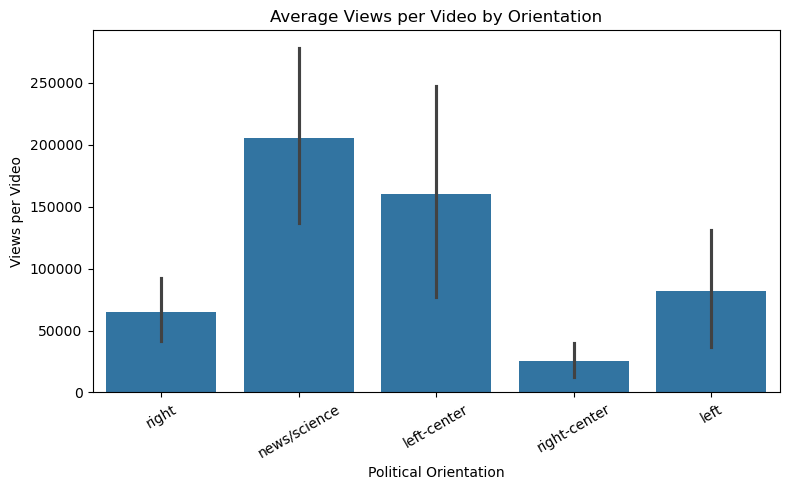

In [6]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_final, x='leaning', y='view_count_per_video')
plt.title('Average Views per Video by Orientation')
plt.ylabel('Views per Video')
plt.xlabel('Political Orientation')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

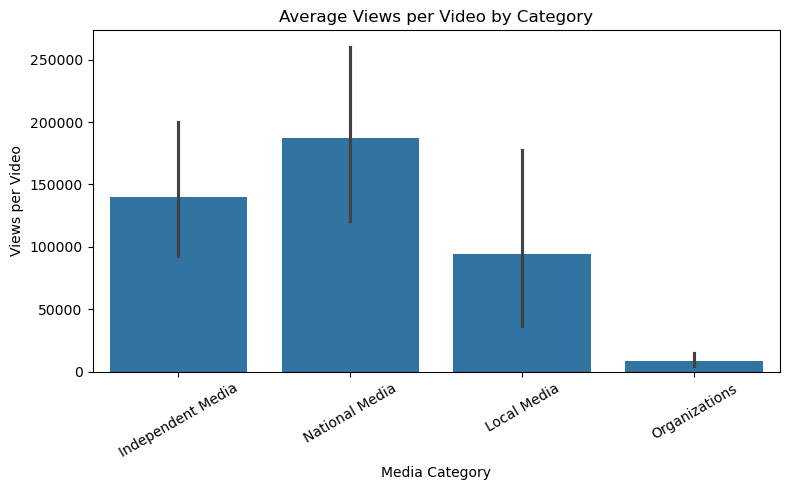

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_final, x='category', y='view_count_per_video')
plt.title('Average Views per Video by Category')
plt.ylabel('Views per Video')
plt.xlabel('Media Category')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

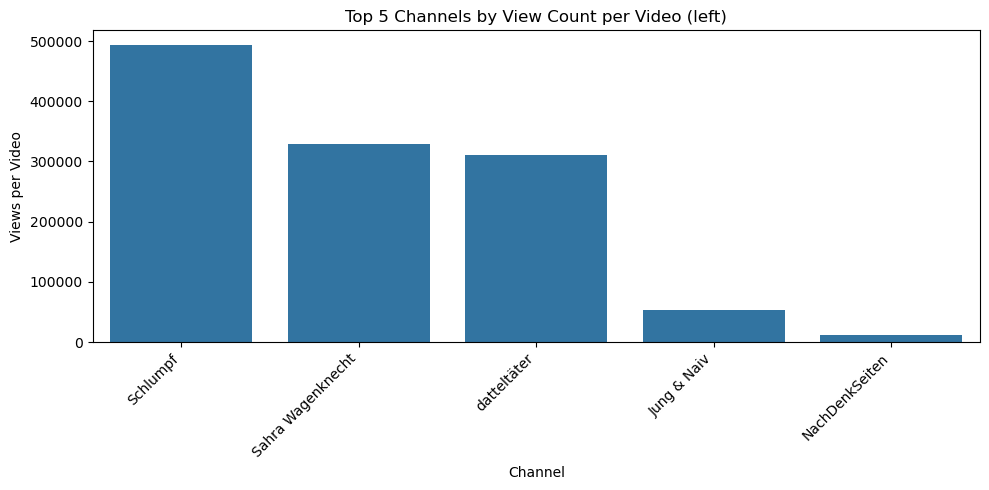

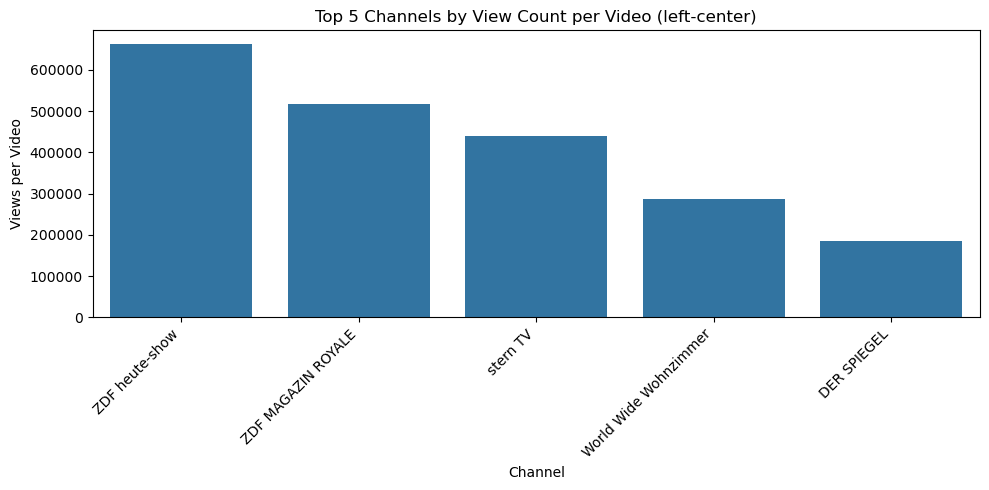

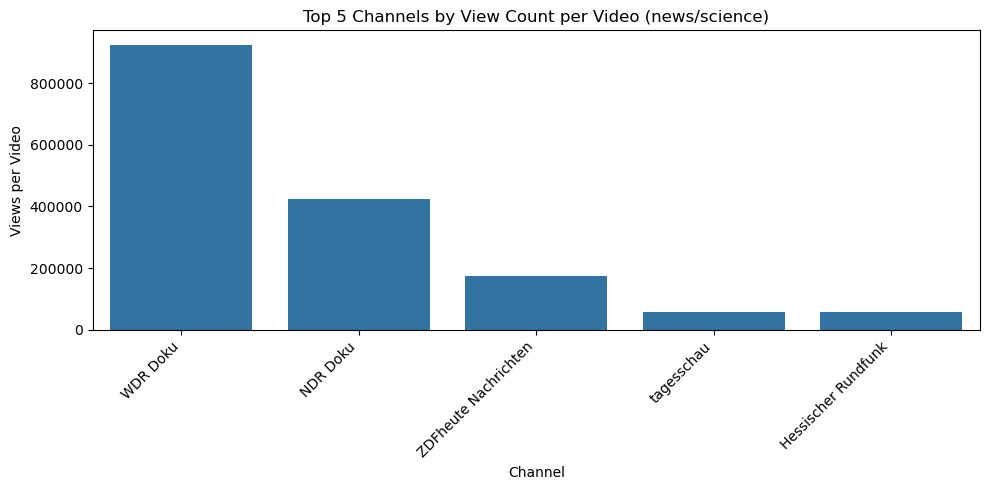

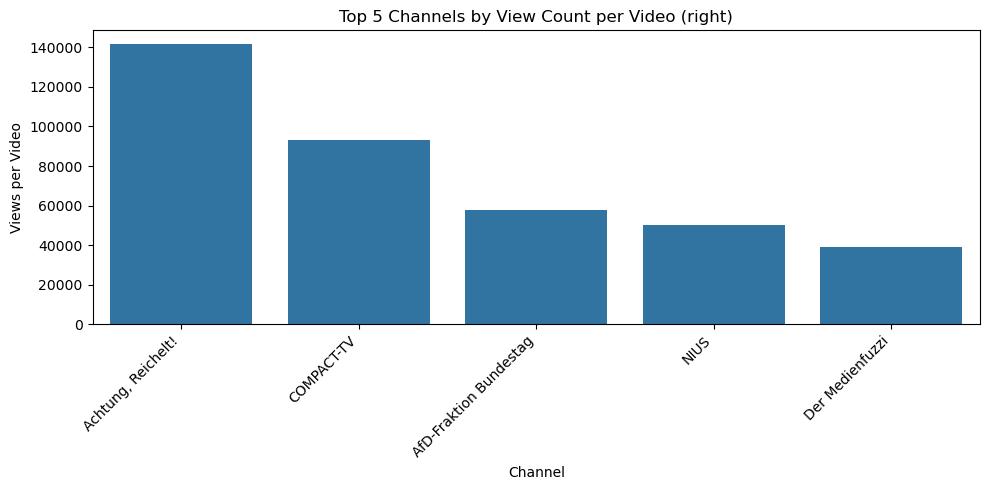

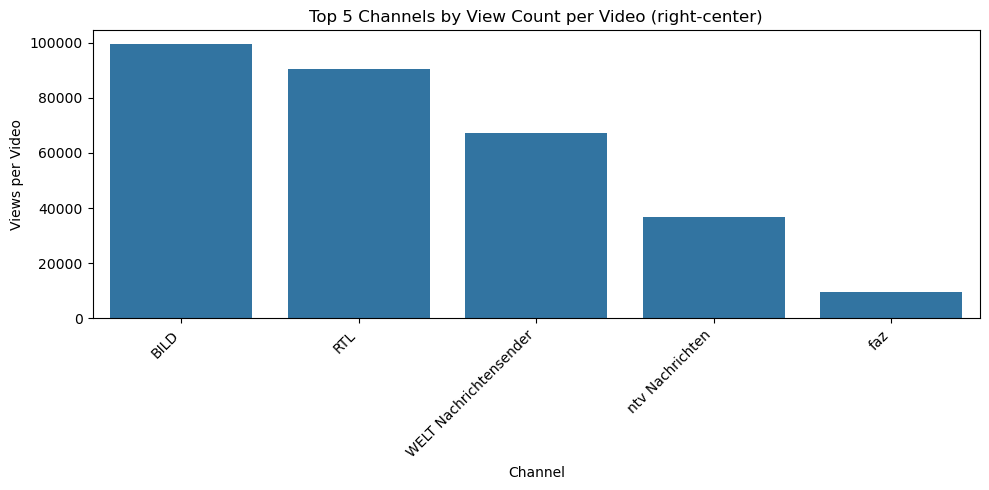

In [9]:
# Step 2: Select top 5 channels per orientation
top5 = (
    df_final.sort_values(['leaning', 'view_count'], ascending=[True, False])
    .groupby('leaning')
    .head(5)
)

# Step 3: Barplot for each orientation
for orientation, subset in top5.groupby('leaning'):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=subset.sort_values('view_count_per_video', ascending=False), x='title',
        y='view_count_per_video',)
    plt.title(f'Top 5 Channels by View Count per Video ({orientation})')
    plt.ylabel('Views per Video')
    plt.xlabel('Channel')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

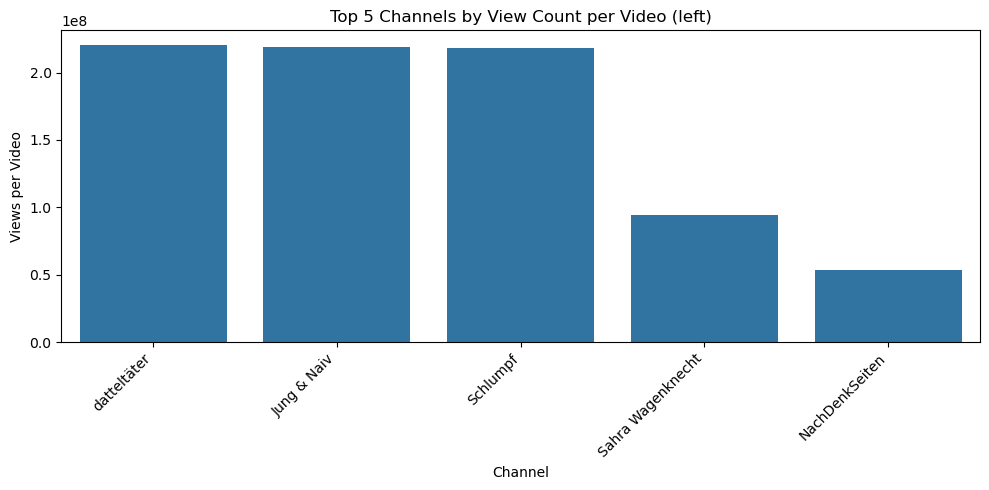

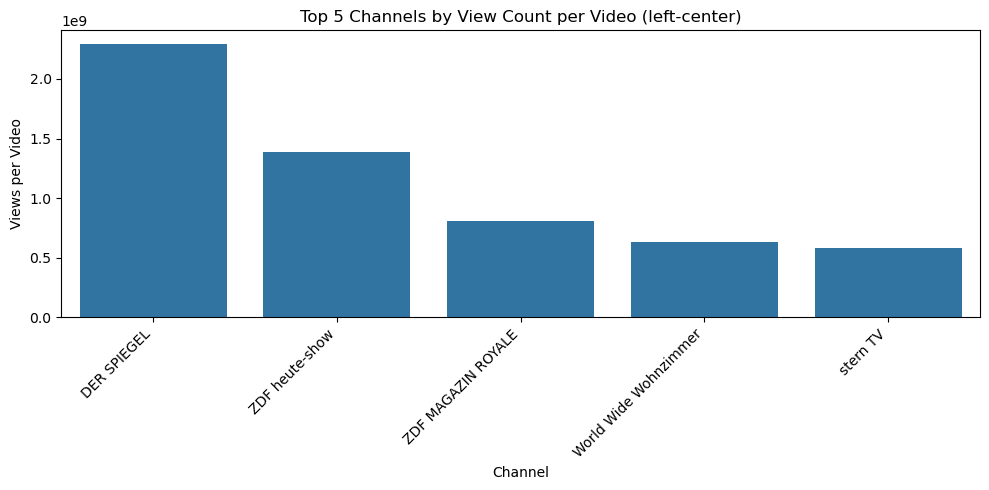

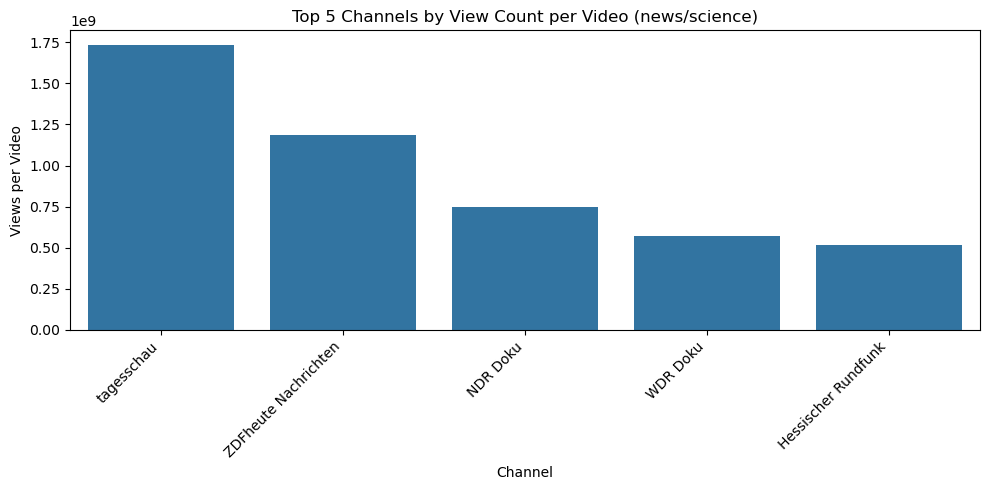

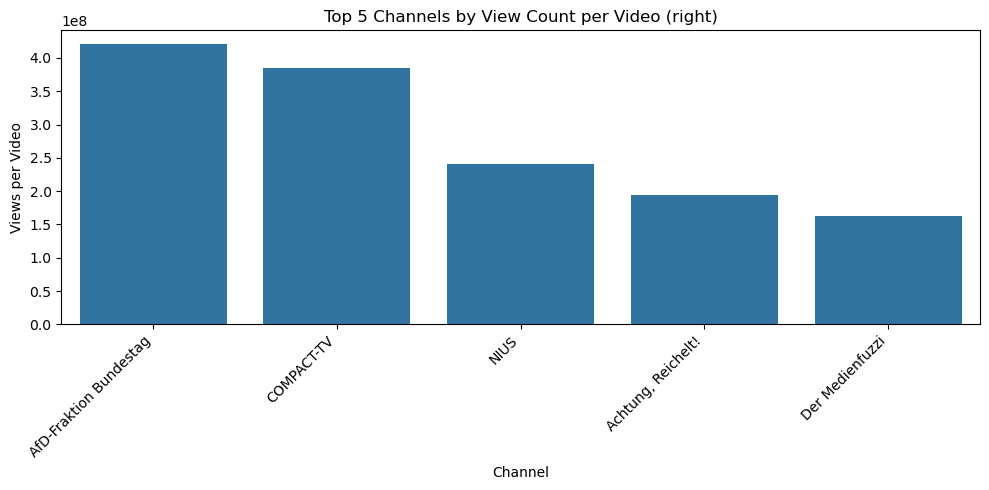

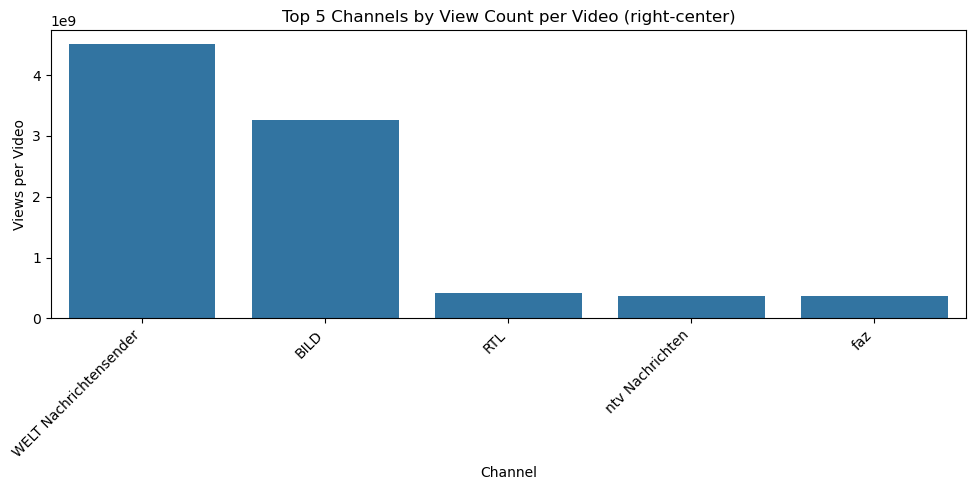

In [177]:

# Step 2: Select top 5 channels per orientation
top5 = (
    df_final.sort_values(['leaning', 'view_count'], ascending=[True, False])
    .groupby('leaning')
    .head(5)
)

# Step 3: Barplot for each orientation
for orientation, subset in top5.groupby('leaning'):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=subset.sort_values('view_count', ascending=False), x='title',
        y='view_count',)
    plt.title(f'Top 5 Channels by View Count per Video ({orientation})')
    plt.ylabel('Views per Video')
    plt.xlabel('Channel')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [ ]:
# Extracting and loading API Key
with open('api_key.txt', 'r') as file:
    api_key = file.readline().strip()

api_key

In [ ]:

# -----------------------------
# CONFIGURATION
# -----------------------------

# API key used for YouTube Data API calls
API_KEY = api_key

# Max number of top-level comments to fetch per video
MAX_COMMENTS_PER_VIDEO = 100

# Max number of videos to crawl comments for per channel
MAX_VIDEOS_PER_CHANNEL = 20

# Number of candidate videos to fetch before selecting top ones by comments
CANDIDATE_VIDEOS = 100

# When falling back, how many pages of replies per thread to fetch (1 page = ≤100 replies)
MAX_REPLY_PAGES_PER_THREAD = 1

# Time to wait between API calls (in seconds)
SLEEP_BETWEEN_CALLS = 0.1

# Daily quota usage cap (YouTube API units)
DAILY_QUOTA_LIMIT = 9500

# Quota used so far
quota_used = 0


# Fixed reference date
REFERENCE_DATE = date(2025, 8, 8)

# Video must be at least 45 days old but not older than 1 year
CUTOFF_DATE = REFERENCE_DATE - timedelta(days=45)
EARLIEST_DATE = REFERENCE_DATE - timedelta(days=365)

# -----------------------------
# FILES
# -----------------------------

# Path to channel list
CHANNELS_FILE = 'data/final_channels.csv'

# Where to store all retrieved comments
COMMENTS_FILE = 'data/youtube_comments.csv'

# Where to store retrieved videos
VIDEO_FILE = 'data/youtube_video_metadata.csv'

# List of already processed video IDs
PROCESSED_VIDEOS_FILE = 'data/processed_videos.txt'

# -----------------------------
# LOAD DATA & CHECKPOINTS
# -----------------------------

# Load channel IDs
channels_df = pd.read_csv(CHANNELS_FILE)

# Load previously saved comments if available
if os.path.exists(COMMENTS_FILE):
    comments_df = pd.read_csv(COMMENTS_FILE)
    all_comments = comments_df.to_dict(orient='records')

    video_df = pd.read_csv(VIDEO_FILE)
    all_videos = video_df.to_dict(orient='records')
else:
    all_comments = []
    all_videos=[]
    

# Load list of processed video IDs
if os.path.exists(PROCESSED_VIDEOS_FILE):
    with open(PROCESSED_VIDEOS_FILE) as f:
        processed_videos = set(line.strip() for line in f)
else:
    processed_videos = set()

# -----------------------------
# API HELPERS
# -----------------------------

# Quota management: increment quota usage and exit if limit is hit
def quota(units=1):
    global quota_used
    if quota_used + units > DAILY_QUOTA_LIMIT:
        print("🛑 Quota would be exceeded. Saving and exiting.")
        save_progress()
        sys.exit(0)
    quota_used += units

# Save comments and processed video IDs to disk
def save_progress():
    pd.DataFrame(all_comments).to_csv(COMMENTS_FILE, index=False)
    pd.DataFrame(all_videos).to_csv(VIDEO_FILE, index=False)

    with open(PROCESSED_VIDEOS_FILE, "w") as f:
        f.write("\n".join(processed_videos))
    print(f"💾 Progress saved at {datetime.now()}")

# Get the uploads playlist ID for a given channel
def get_uploads_playlist_id(channel_id):
    quota(1)  # API call costs 1 unit
    url = 'https://www.googleapis.com/youtube/v3/channels'
    params = {'part': 'contentDetails', 'id': channel_id, 'key': API_KEY}
    r = requests.get(url, params=params).json()
    try:
        return r['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    except (KeyError, IndexError):
        return None

# Fetch video IDs from the uploads playlist, filtered by date
def get_video_ids_from_playlist(playlist_id, max_needed=CANDIDATE_VIDEOS):
    video_ids = []
    page_token = None
    while len(video_ids) < max_needed:
        url = 'https://www.googleapis.com/youtube/v3/playlistItems'
        params = {
            'part': 'contentDetails',
            'playlistId': playlist_id,
            'maxResults': 50,
            'key': API_KEY,
            'pageToken': page_token
        }
        quota(1)
        r = requests.get(url, params=params).json()
        items = r.get('items', [])
        for item in items:
            vid = item['contentDetails']['videoId']
            published = item['contentDetails'].get('videoPublishedAt')
            if published:
                try:
                    published_dt = datetime.strptime(published, "%Y-%m-%dT%H:%M:%SZ").date()
                    if EARLIEST_DATE <= published_dt <= CUTOFF_DATE:
                        video_ids.append(vid)
                        if len(video_ids) >= max_needed:
                            return video_ids
                except:
                    continue
        if 'nextPageToken' not in r:
            break
        page_token = r['nextPageToken']
        time.sleep(SLEEP_BETWEEN_CALLS)
    return video_ids

# Get metadata for each video (title, description, category, tags, topics, comment, view, and like count, publish date)
def get_videos_metadata(video_ids):
    metadata = []
    for i in range(0, len(video_ids), 50):
        batch = video_ids[i:i+50]
        url = "https://www.googleapis.com/youtube/v3/videos"
        params = {
            "part": "snippet,statistics,topicDetails",
            "id": ",".join(batch),
            "key": API_KEY
        }
        quota(1)
        r = requests.get(url, params=params).json()
        for item in r.get("items", []):
            snippet = item.get("snippet", {})
            stats = item.get("statistics", {})
            published = snippet.get("publishedAt")
            try:
                published_dt = datetime.strptime(published, "%Y-%m-%dT%H:%M:%SZ").date()
            except:
                continue

            metadata.append({
                'video_id': item['id'],
                'published_at': published_dt,
                'comment_count': int(stats.get('commentCount', 0)),
                'view_count': int(stats.get('viewCount', 0)),
                'like_count': int(stats.get('likeCount', 0)),
                'title': snippet.get('title'),
                'description': snippet.get('description'),
                'category_id': snippet.get('categoryId'),
                'tags': "; ".join(snippet.get('tags', [])),  # Join list to single string
                'topics': item.get('topicDetails', {}).get('topicCategories', [])
            })
        time.sleep(SLEEP_BETWEEN_CALLS)
    return metadata


# Fetch top-level comments and replies for a video
def get_comments(video_id, max_comments=100):
    """
    Hybrid:
      1) Fetch top-level threads with embedded replies via commentThreads.list(part=snippet,replies).
      2) Use embedded replies when available.
      3) If totalReplyCount > embedded_count, fall back to comments.list(parentId=...),
         bounded by MAX_REPLY_PAGES_PER_THREAD per thread. No per-video budget.
    """
    comments = []
    page_token = None
    top_level_count = 0
    success = False

    while True:
        if quota_used >= DAILY_QUOTA_LIMIT or top_level_count >= max_comments:
            break

        quota(1)  # commentThreads.list costs 1 unit per page
        url = 'https://www.googleapis.com/youtube/v3/commentThreads'
        params = {
            'part': 'snippet,replies',
            'videoId': video_id,
            'maxResults': min(100, max_comments - top_level_count),
            'key': API_KEY,
            'pageToken': page_token,
            'order': 'relevance'
        }
        r = requests.get(url, params=params).json()

        if 'items' not in r:
            break
        success = True

        for thread in r['items']:
            if top_level_count >= max_comments:
                break

            top_obj = thread['snippet']['topLevelComment']
            t_snip = top_obj['snippet']
            top_comment_id = top_obj['id']
            total_reply_count = thread['snippet'].get('totalReplyCount', 0)

            # Add top-level comment
            comments.append({
                'video_id': video_id,
                'comment_id': top_comment_id,
                'comment_text': t_snip.get('textDisplay'),
                'author_channel_id': t_snip.get('authorChannelId', {}).get('value'),
                'author_display_name': t_snip.get('authorDisplayName'),
                'published_at': t_snip.get('publishedAt'),
                'is_reply': False,
                'parent_comment_id': None
            })
            top_level_count += 1

            # 1) Use embedded replies (if any)
            embedded_count = 0
            if 'replies' in thread and 'comments' in thread['replies']:
                for rep in thread['replies']['comments']:
                    rs = rep['snippet']
                    comments.append({
                        'video_id': video_id,
                        'comment_id': rep['id'],
                        'comment_text': rs.get('textDisplay'),
                        'author_channel_id': rs.get('authorChannelId', {}).get('value'),
                        'author_display_name': rs.get('authorDisplayName'),
                        'published_at': rs.get('publishedAt'),
                        'is_reply': True,
                        'parent_comment_id': top_comment_id
                    })
                embedded_count = len(thread['replies']['comments'])

            # 2) Fall back to comments.list only if needed (no per-video cap)
            if total_reply_count > embedded_count and MAX_REPLY_PAGES_PER_THREAD > 0:
                fetched, _pages_spent = get_replies(
                    parent_id=top_comment_id,
                    video_id=video_id,
                    max_pages=MAX_REPLY_PAGES_PER_THREAD
                )
                comments.extend(fetched)

        if 'nextPageToken' in r and top_level_count < max_comments:
            page_token = r['nextPageToken']
            time.sleep(SLEEP_BETWEEN_CALLS)
        else:
            break

    return comments, success

# Fetch replies to a top-level comment
def get_replies(parent_id, video_id, max_pages=1):
    """
    Fetch replies for a single thread via comments.list(parentId=...).
    Returns (replies_list, pages_spent).
    No per-video budget; respects DAILY_QUOTA_LIMIT and per-thread cap.
    """
    replies = []
    page_token = None
    pages_spent = 0

    while pages_spent < max_pages and quota_used < DAILY_QUOTA_LIMIT:
        quota(1)  # comments.list costs 1 unit per page
        url = 'https://www.googleapis.com/youtube/v3/comments'
        params = {
            'part': 'snippet',
            'parentId': parent_id,
            'maxResults': 100,
            'key': API_KEY,
            'pageToken': page_token
        }
        r = requests.get(url, params=params).json()
        pages_spent += 1

        for item in r.get('items', []):
            s = item['snippet']
            replies.append({
                'video_id': video_id,
                'comment_id': item['id'],
                'comment_text': s.get('textDisplay'),
                'author_channel_id': s.get('authorChannelId', {}).get('value'),
                'author_display_name': s.get('authorDisplayName'),
                'published_at': s.get('publishedAt'),
                'is_reply': True,
                'parent_comment_id': parent_id
            })

        if 'nextPageToken' not in r or pages_spent >= max_pages:
            break

        page_token = r['nextPageToken']
        time.sleep(SLEEP_BETWEEN_CALLS)

    return replies, pages_spent

# # -----------------------------
# # MAIN LOOP
# # -----------------------------

try:
    for idx, row in tqdm(channels_df.iterrows(), total=len(channels_df), desc="📺 Channels", dynamic_ncols=True):
        channel_id = row['channel_id']
        print(f"\n📺 Channel: {channel_id}",flush=True)

        # Get uploads playlist for the channel
        playlist_id = get_uploads_playlist_id(channel_id)
        if not playlist_id:
            print("  ❌ No uploads playlist.")
            continue

        print("  📥 Fetching candidate videos...", flush=True)
        video_ids = get_video_ids_from_playlist(playlist_id, max_needed=CANDIDATE_VIDEOS)
        print(f"  🎞️ {len(video_ids)} videos after filtering by date.", flush=True)
        if not video_ids:
            continue

        # Get metadata and select top videos by comment count
        video_meta = get_videos_metadata(video_ids)
        selected = sorted(video_meta, key=lambda v: v['comment_count'], reverse=True)[:MAX_VIDEOS_PER_CHANNEL]
        print(f"  ✅ Selected {len(selected)} most-commented videos.", flush=True)

        for vid_meta in tqdm(selected, desc=f"  🎞️ Videos for {channel_id}", leave=False, dynamic_ncols=True):
            vid = vid_meta['video_id']
            if vid in processed_videos:
                continue

            print(f"    💬 Crawling video: {vid} | Comments: {vid_meta['comment_count']}", flush=True)

            # Fetch comments and check API success
            comments, success = get_comments(vid)
            if not success:
                print(f"⚠️ API failed or quota exhausted for {vid}, skipping...", flush=True)
                continue

            # Mark video as processed
            processed_videos.add(vid)

            vid_meta_copy = vid_meta.copy()
            vid_meta_copy["video_channel_id"] = channel_id
            all_videos.append(vid_meta_copy)

            # Enrich comments with metadata
            for c in comments:
                c['topics'] = "; ".join(vid_meta.get('topics', []))
                c["video_channel_id"] = channel_id
            all_comments.extend(comments)

            print(f"      ➕ {len(comments)} comments")
            save_progress()
            time.sleep(SLEEP_BETWEEN_CALLS)

except KeyboardInterrupt:
    print("\n🛑 Interrupted. Saving progress...")
    save_progress()

In [ ]:
channels_df=pd.read_csv("data/final_channels.csv")

In [22]:
# Per-user share of distinct channels they comment on, by leaning: 
# “For each user, what fraction of the different channels they touched are Left/Center/Right/etc.?”
# Merge comments with channel leaning info

df_merged = comments_df.merge(
    channels_df[["channel_id", "title", "leaning"]],
    left_on="video_channel_id", right_on="channel_id", how="left"
)

### Re-crawl for lost channels and channels with less than 20 videos

In [ ]:
import os
import sys
import pandas as pd
import requests
import time
from datetime import date, timedelta, datetime
from tqdm import tqdm

# -----------------------------
# CONFIG
# -----------------------------
API_KEY = api_key  # Replace if needed
COMMENTS_FILE = 'data/youtube_comments.csv'
VIDEO_FILE = 'data/youtube_video_metadata.csv'

REFERENCE_DATE = date(2025, 8, 8)
CUTOFF_DATE = REFERENCE_DATE - timedelta(days=45)
EARLIEST_DATE = REFERENCE_DATE - timedelta(days=365)

MAX_COMMENTS_PER_VIDEO = 100
MAX_VIDEOS_PER_CHANNEL = 20
CANDIDATE_VIDEOS = 100  

MAX_REPLY_PAGES_PER_THREAD = 1
SLEEP_BETWEEN_CALLS = 0.1
DAILY_QUOTA_LIMIT = 10000
quota_used = 0

# -----------------------------
# Load existing data (ONLY comments drive "already fetched")
# -----------------------------
try:
    existing_comments_df = pd.read_csv(COMMENTS_FILE, dtype=str, low_memory=False)
except Exception:
    existing_comments_df = pd.DataFrame(columns=[
        'video_id','comment_id','comment_text','author_channel_id','author_display_name',
        'published_at','is_reply','parent_comment_id','topics','video_channel_id'
    ])

try:
    channel_df = pd.read_csv("data/final_channels.csv")
except Exception:
    raise FileNotFoundError("Cannot load channel_df. Ensure 'data/final_channels.csv' exists.")

# Global sets from comments only
existing_video_ids_all = set(existing_comments_df['video_id']) if not existing_comments_df.empty else set()
existing_comment_ids = set(existing_comments_df['comment_id']) if not existing_comments_df.empty else set()

# Channels to retry
under_20_channels = ['Apollo News', 'Belltower News', 'Berliner Zeitung', 'BILD', 'Bundeszentrale für politische Bildung / bpb', 'COMPACT-TV', 'Deutschlandfunk Nova', 'dpa', 'EXPRESS', 'faz', 'Frankfurter Rundschau', 'General-Anzeiger Bonn', 'Handelsblatt', 'Journalistenwatch', 'junge Welt', 'Merkur.de', 'Berliner Morgenpost', 'ntv Nachrichten', 'nd.aktuell', 'News.de', 'NIUS', 'NordkurierTV', 'Rheinische Post', 'RUHR24', 'SaarbrueckerZeitung', 'Solinger Tageblatt', 'DER SPIEGEL', 'Süddeutsche Zeitung', 'Super Tipp Medien GmbH', 't-online', 'TAG24 NEWS', 'tagesschau', 'taz', 'Volksfreund TV', 'Westdeutsche Zeitung', 'ZDF', 'DIE ZEIT ', 'Rayk Anders', 'Peng! Consulting', 'Weckerswelt', 'Moritz Neumeier', 'Filmpirat*innen', 'leftvision', 'acTVism Munich', 'Fraktion DIE LINKE. im Bundestag i.L.', 'Michael Stürzenberger', 'Junge Nationalisten', 'Junge Tat', 'Clownswelt', 'eingollan', 'Boris von Morgenstern', 'Der Medienfuzzi', 'Patrick Schröder', 'Frank Kraemer', 'Krautzone', 'Nico Semsrott', 'MAITHINK X', 'DIE LINKE', 'CDU', 'Jung & Naiv', 'SPD', 'Tim Kellner', 'Neverforgetniki', 'SWR', "NDR auf'm Land", 'debate//de:hate', 'AmadeuAntonioFound', 'Amadeu Antonio Stiftung', '#NichtEgal', 'Laut gegen Nazis', 'BILD Promis', 'Abdelkratie', 'wahre welle TV', 'flutertv', 'AuswaertigesAmtDE', 'Alumniportal Deutschland', 'Rosa-Luxemburg-Konferenz', 'Melodie & Rhythmus', 'RTL', 'RealTalk - mit Julius Böhm', 'RP ONLINE - WIR SIND WELT', 'RGA Remscheid', 'ZDF Comedy', 'logo!', 'Cross Point', 'Junge Freiheit Podcast', 'Ketzer-Kirche-Live', 'Terra X History', 'Nico Semsrott [im TV]', 'Phil Laude', 'World Wide Wohnzimmer', 'Parshad', 'Rosa-Luxemburg-Stiftung', 'SPD-Fraktion im Bundestag', 'SCHAU HIN!', 'PUR+', 'CDU•CSU Fraktion', 'Grüne im Bundestag', 'Junge Union Deutschlands', 'Jusos', 'Junge Alternative', 'GRÜNE JUGEND', "Linksjugend ['solid]", 'Bayerischer Rundfunk', 'MDR Mitteldeutscher Rundfunk', 'rbb', 'Saarländischer Rundfunk', 'WELT Nachrichtensender', 'Simplicissimus']
special_df = channel_df[channel_df['title'].isin(under_20_channels)][['channel_id', 'title']].drop_duplicates()

# -----------------------------
# Buffers (incremental save after each video)
# -----------------------------
new_all_comments = []
new_all_videos = []

# Column order for comments
EXPECTED_COMMENT_COLUMNS = [
    'video_id', 'comment_id', 'comment_text', 'author_channel_id', 'author_display_name',
    'published_at', 'is_reply', 'parent_comment_id', 'topics', 'video_channel_id'
]

# -----------------------------
# Quota + Save helpers
# -----------------------------
def save_results():
    """Merge buffers into existing CSVs, de-duplicate, write to disk, then CLEAR BUFFERS & refresh sets."""
    # Prepare new DFs
    new_comments_df = pd.DataFrame(new_all_comments)
    for col in EXPECTED_COMMENT_COLUMNS:
        if col not in new_comments_df.columns:
            new_comments_df[col] = pd.Series(dtype=str)
    new_comments_df = new_comments_df[EXPECTED_COMMENT_COLUMNS]

    new_videos_df = pd.DataFrame(new_all_videos)

    # Merge with on-disk CSVs
    try:
        old_comments_df = pd.read_csv(COMMENTS_FILE, dtype=str, low_memory=False)
        final_comments_df = pd.concat([old_comments_df, new_comments_df], ignore_index=True)
    except Exception:
        final_comments_df = new_comments_df

    try:
        old_video_df = pd.read_csv(VIDEO_FILE, dtype=str, low_memory=False)
        final_videos_df = pd.concat([old_video_df, new_videos_df], ignore_index=True)
    except Exception:
        final_videos_df = new_videos_df

    # De-duplicate by IDs
    if not final_comments_df.empty and 'comment_id' in final_comments_df.columns:
        final_comments_df.drop_duplicates(subset=['comment_id'], inplace=True, keep='first')
    if not final_videos_df.empty and 'video_id' in final_videos_df.columns:
        final_videos_df.drop_duplicates(subset=['video_id'], inplace=True, keep='first')

    # Write
    final_comments_df.to_csv(COMMENTS_FILE, index=False)
    final_videos_df.to_csv(VIDEO_FILE, index=False)

    print(f"💾 Progress saved — comments: {len(final_comments_df)} | videos: {len(final_videos_df)}", flush=True)

    # Clear Buffers
    new_all_comments.clear()
    new_all_videos.clear()

    # Refresh in-memory sets from disk (comments drive "already fetched")
    try:
        reloaded_comments = pd.read_csv(COMMENTS_FILE, dtype=str, low_memory=False)
        if not reloaded_comments.empty:
            existing_video_ids_all.clear()
            existing_video_ids_all.update(reloaded_comments['video_id'].dropna().tolist())
            existing_comment_ids.clear()
            existing_comment_ids.update(reloaded_comments['comment_id'].dropna().tolist())
    except Exception:
        pass

def quota(units=1):
    """Increment quota usage; if exceeding, save and exit safely."""
    global quota_used
    if quota_used + units > DAILY_QUOTA_LIMIT:
        print("🛑 Quota would be exceeded. Saving and exiting.", flush=True)
        save_results()
        sys.exit(0)
    quota_used += units

# -----------------------------
# Replies helper (one page max, as configured)
# -----------------------------
def get_replies(parent_id, video_id, max_pages=1):
    replies = []
    page_token = None
    pages_spent = 0
    while pages_spent < max_pages and quota_used < DAILY_QUOTA_LIMIT:
        quota(1)  # comments.list = 1 unit
        url = 'https://www.googleapis.com/youtube/v3/comments'
        params = {
            'part': 'snippet',
            'parentId': parent_id,
            'maxResults': 100,
            'key': API_KEY,
            'pageToken': page_token
        }
        r = requests.get(url, params=params).json()
        pages_spent += 1

        for item in r.get('items', []):
            s = item['snippet']
            cid = item['id']
            if cid in existing_comment_ids:
                continue
            replies.append({
                'video_id': video_id,
                'comment_id': cid,
                'comment_text': s.get('textDisplay'),
                'author_channel_id': s.get('authorChannelId', {}).get('value'),
                'author_display_name': s.get('authorDisplayName'),
                'published_at': s.get('publishedAt'),
                'is_reply': True,
                'parent_comment_id': parent_id
            })
            existing_comment_ids.add(cid)

        if 'nextPageToken' not in r or pages_spent >= max_pages:
            break
        page_token = r['nextPageToken']
        time.sleep(SLEEP_BETWEEN_CALLS)

    return replies, pages_spent


# -----------------------------
# Main crawl (ensure 20 videos per channel: pre-existing + new)
# -----------------------------
print(f"🔁 Retrying crawl for {len(special_df)} channels with <20 videos (comments.csv is the only source of truth)")
try:
    for idx, row in tqdm(special_df.iterrows(), total=len(special_df), desc="📺 Retrying Channels"):
        channel_id = row['channel_id']
        channel_title = row['title']
        print(f"\n📺 Channel: {channel_title} ({channel_id})", flush=True)

        # How many videos for this channel already fetched (per comments.csv)?
        if 'video_channel_id' in existing_comments_df.columns:
            already_for_channel = set(
                existing_comments_df.loc[
                    existing_comments_df['video_channel_id'] == channel_id, 'video_id'
                ].dropna().tolist()
            )
        else:
            # Fallback: if channel id wasn't stored historically, use global (coarser)
            already_for_channel = set(
                vid for vid in existing_video_ids_all
            )

        already_count = len(already_for_channel)
        remaining_target = max(0, MAX_VIDEOS_PER_CHANNEL - already_count)

        if remaining_target == 0:
            print(f"  ✅ Channel already has {already_count} videos in comments.csv — skipping.", flush=True)
            continue

        # Get uploads playlist
        playlist_id = get_uploads_playlist_id(channel_id)
        if not playlist_id:
            print("  ❌ No uploads playlist.", flush=True)
            continue

        # Fetch candidate videos (playlist paging with date window inside helper)
        video_ids = get_video_ids_from_playlist(playlist_id, max_needed=CANDIDATE_VIDEOS)
        print(f"  🎞️ Retrieved {len(video_ids)} date-eligible candidates", flush=True)
        if not video_ids:
            continue

        # Filter out videos already present in comments (global set) OR already_for_channel
        candidates = [vid for vid in video_ids if vid not in existing_video_ids_all]

        if not candidates:
            print("  ⚠️ All candidates are already fetched in comments.csv.", flush=True)
            continue

        # Pull metadata for remaining candidates
        video_meta = get_videos_metadata(candidates)

        # Select up to 'remaining_target' by comment_count
        selected = sorted(video_meta, key=lambda v: v.get('comment_count', 0), reverse=True)[:remaining_target]
        print(f"  ✅ Selected {len(selected)} videos to reach {MAX_VIDEOS_PER_CHANNEL} total", flush=True)

        # For each selected video: write metadata (optional) and crawl comments
        processed_for_channel = 0
        for vid_meta in tqdm(selected, desc=f"  🎞️ Videos for {channel_title}", leave=False):
            vid = vid_meta['video_id']

            # write/update metadata (not used for skipping, but useful to keep)
            vid_meta_copy = vid_meta.copy()
            vid_meta_copy["video_channel_id"] = channel_id
            new_all_videos.append(vid_meta_copy)  # drop_duplicates on save

            #  crawl comments
            print(f"    💬 Crawling video: {vid} | Comments: {vid_meta.get('comment_count', 0)}", flush=True)

            comments = []
            page_token = None
            top_level_count = 0
            success = None

            while True:
                if quota_used >= DAILY_QUOTA_LIMIT or top_level_count >= MAX_COMMENTS_PER_VIDEO:
                    break

                quota(1) 
                r = requests.get(
                    'https://www.googleapis.com/youtube/v3/commentThreads',
                    params={
                        'part': 'snippet,replies',
                        'videoId': vid,
                        'maxResults': min(100, MAX_COMMENTS_PER_VIDEO - top_level_count),
                        'key': API_KEY,
                        'pageToken': page_token,
                        'order': 'relevance'
                    }
                ).json()

                if not isinstance(r, dict) or 'items' not in r:
                    print(f"⚠️ Malformed result for {vid}", flush=True)
                    success = False
                    break
                elif not r['items']:
                    print(f"⚠️ No comments for {vid}", flush=True)
                    success = True
                    break
                else:
                    success = True

                for thread in r['items']:
                    if top_level_count >= MAX_COMMENTS_PER_VIDEO:
                        break

                    top_obj = thread['snippet']['topLevelComment']
                    t_snip = top_obj['snippet']
                    top_comment_id = top_obj['id']
                    total_reply_count = thread['snippet'].get('totalReplyCount', 0)

                    if top_comment_id not in existing_comment_ids:
                        comments.append({
                            'video_id': vid,
                            'comment_id': top_comment_id,
                            'comment_text': t_snip.get('textDisplay'),
                            'author_channel_id': t_snip.get('authorChannelId', {}).get('value'),
                            'author_display_name': t_snip.get('authorDisplayName'),
                            'published_at': t_snip.get('publishedAt'),
                            'is_reply': False,
                            'parent_comment_id': None,
                            'topics': "; ".join(vid_meta.get('topics', [])),
                            'video_channel_id': channel_id
                        })
                        existing_comment_ids.add(top_comment_id)
                    top_level_count += 1

                    embedded = thread.get('replies', {}).get('comments', []) or []
                    for rep in embedded:
                        rep_id = rep['id']
                        if rep_id in existing_comment_ids:
                            continue
                        rs = rep['snippet']
                        comments.append({
                            'video_id': vid,
                            'comment_id': rep_id,
                            'comment_text': rs.get('textDisplay'),
                            'author_channel_id': rs.get('authorChannelId', {}).get('value'),
                            'author_display_name': rs.get('authorDisplayName'),
                            'published_at': rs.get('publishedAt'),
                            'is_reply': True,
                            'parent_comment_id': top_comment_id,
                            'topics': "; ".join(vid_meta.get('topics', [])),
                            'video_channel_id': channel_id
                        })
                        existing_comment_ids.add(rep_id)

                    if total_reply_count > len(embedded) and MAX_REPLY_PAGES_PER_THREAD > 0:
                        fetched, _ = get_replies(top_comment_id, vid, MAX_REPLY_PAGES_PER_THREAD)
                        for fc in fetched:
                            fc['topics'] = "; ".join(vid_meta.get('topics', []))
                            fc['video_channel_id'] = channel_id
                        comments.extend(fetched)

                if 'nextPageToken' in r and top_level_count < MAX_COMMENTS_PER_VIDEO:
                    page_token = r['nextPageToken']
                    time.sleep(SLEEP_BETWEEN_CALLS)
                else:
                    break

            if not success:
                continue

            if comments:
                new_all_comments.extend(comments)

            save_results()  

            # Mark this video as fetched in-memory
            existing_video_ids_all.add(vid)
            already_for_channel.add(vid)
            processed_for_channel += 1

            print(f"      ➕ {len(comments)} comments (saved)", flush=True)
            time.sleep(SLEEP_BETWEEN_CALLS)

            # Stop early if we already reached the per-channel target during this run
            if len(already_for_channel) >= MAX_VIDEOS_PER_CHANNEL:
                print(f"  ✅ Reached {MAX_VIDEOS_PER_CHANNEL} videos for {channel_title}.", flush=True)
                break

        # Rrefresh the base DataFrame view for the next channel’s initial count
        if processed_for_channel > 0:
            try:
                existing_comments_df = pd.read_csv(COMMENTS_FILE, dtype=str, low_memory=False)
            except Exception:
                pass

except KeyboardInterrupt:
    print("🛑 Interrupted by user. Saving progress...", flush=True)
    save_results()
except SystemExit:
    pass
except Exception as e:
    print(f"❌ Unhandled error: {e}. Saving progress before exit.", flush=True)
    save_results()
else:
    print("✅ Completed crawl. Final save...", flush=True)
    save_results()


💾 Progress saved — comments: 701954 | videos: 3326
      ➕ 20 comments (saved)


    💬 Crawling video: 869kYkT3RLk | Comments: 21
💾 Progress saved — comments: 701973 | videos: 3326
      ➕ 19 comments (saved)
  ✅ Reached 20 videos for Saarländischer Rundfunk.


📺 Retrying Channels:  98%|█████████▊| 107/109 [6:18:42<08:23, 251.95s/it]


📺 Channel: WELT Nachrichtensender (UCZMsvbAhhRblVGXmEXW8TSA)
  🎞️ Retrieved 100 date-eligible candidates
  ✅ Selected 20 videos to reach 20 total


    💬 Crawling video: 66xCd6OVKlY | Comments: 0
⚠️ Malformed result for 66xCd6OVKlY
    💬 Crawling video: QmWkOHBX1ow | Comments: 0
⚠️ Malformed result for QmWkOHBX1ow


    💬 Crawling video: Wodh3tr6SGo | Comments: 0
⚠️ Malformed result for Wodh3tr6SGo
    💬 Crawling video: 14DE3603uSc | Comments: 0
⚠️ Malformed result for 14DE3603uSc


    💬 Crawling video: o361z68q4dk | Comments: 0
⚠️ Malformed result for o361z68q4dk
    💬 Crawling video: WCkanVOyljQ | Comments: 0
⚠️ Malformed result for WCkanVOyljQ


    💬 Crawling video: utv-sZqqmjE | Comments: 0
⚠️ Malformed result for utv-sZqqmjE
    💬 Crawling video: -byLmV1D-t0 | Comments: 0
⚠️ Malformed result for -byLmV1D-t0


    💬 Crawling video: OtSCMtya9Ho | Comments: 0
⚠️ Malformed result for OtSCMtya9Ho
    💬 Crawling video: u_iP--rCqK8 | Comments: 0
⚠️ Malformed result for u_iP--rCqK8


    💬 Crawling video: _AB-0IcoDDI | Comments: 0
⚠️ Malformed result for _AB-0IcoDDI


    💬 Crawling video: eE0omYjAiyI | Comments: 0
⚠️ Malformed result for eE0omYjAiyI
    💬 Crawling video: i-Vcu7lqjHw | Comments: 0
⚠️ Malformed result for i-Vcu7lqjHw


    💬 Crawling video: nXiUXG5pJPI | Comments: 0
⚠️ Malformed result for nXiUXG5pJPI


    💬 Crawling video: 6tyXRHsOJ3Q | Comments: 0
⚠️ Malformed result for 6tyXRHsOJ3Q
    💬 Crawling video: H2e2xooOrag | Comments: 0
⚠️ Malformed result for H2e2xooOrag


    💬 Crawling video: EI9mf4ALJAE | Comments: 0
⚠️ Malformed result for EI9mf4ALJAE
    💬 Crawling video: w3K8WQIyLuo | Comments: 0
⚠️ Malformed result for w3K8WQIyLuo


    💬 Crawling video: RgHp-n1q_nk | Comments: 0
⚠️ Malformed result for RgHp-n1q_nk
    💬 Crawling video: QJojl7KjxFc | Comments: 0
⚠️ Malformed result for QJojl7KjxFc


📺 Retrying Channels:  99%|█████████▉| 108/109 [6:19:04<03:03, 183.10s/it]


📺 Channel: Simplicissimus (UCKGMHVipEvuZudhHD05FOYA)
  🎞️ Retrieved 47 date-eligible candidates
  ✅ Selected 6 videos to reach 20 total


    💬 Crawling video: XvuibEYkqx4 | Comments: 3173
💾 Progress saved — comments: 702692 | videos: 3346
      ➕ 719 comments (saved)


    💬 Crawling video: i10MDTGI_v8 | Comments: 3043
💾 Progress saved — comments: 703405 | videos: 3346
      ➕ 713 comments (saved)


    💬 Crawling video: cgASnPT1rBM | Comments: 2778
💾 Progress saved — comments: 704052 | videos: 3346
      ➕ 647 comments (saved)


    💬 Crawling video: REBqwWwBphk | Comments: 2713
💾 Progress saved — comments: 704699 | videos: 3346
      ➕ 647 comments (saved)


    💬 Crawling video: 5_ZnHSZ6xTw | Comments: 2590
💾 Progress saved — comments: 705373 | videos: 3346
      ➕ 674 comments (saved)


    💬 Crawling video: oQZqIvY9x1c | Comments: 2578
💾 Progress saved — comments: 705744 | videos: 3346
      ➕ 371 comments (saved)
  ✅ Reached 20 videos for Simplicissimus.


📺 Retrying Channels: 100%|██████████| 109/109 [6:23:38<00:00, 211.18s/it]

✅ Completed crawl. Final save...


💾 Progress saved — comments: 705744 | videos: 3346


## Pre-Process and Merge

In [68]:
comments_df=pd.read_csv("data/youtube_comments.csv")
channel_df=pd.read_csv("data/final_channels.csv")
videos_df=pd.read_csv("data/youtube_video_metadata.csv")
videos_df.drop_duplicates(inplace=True, keep='first')

In [14]:
REFERENCE_DATE = date(2025, 8, 8)
REF = pd.Timestamp(REFERENCE_DATE, tz="UTC")
CUTOFF = REF - pd.Timedelta(days=45)
EARLIEST = REF - pd.Timedelta(days=365)

videos_df = videos_df.copy()
videos_df["published_at"] = pd.to_datetime(videos_df["published_at"], utc=True, errors="coerce")

videos_win = videos_df.loc[
    videos_df["published_at"].between(EARLIEST, CUTOFF, inclusive="both")
].copy()


In [18]:
channel_cols = (
    channel_df[["channel_id", "title", "leaning","category"]]
    .rename(columns={"title": "channel_title",
                     "category":"channel_category"})
)

video_cols = (
    videos_win[["video_id", "title", "description", "published_at", "comment_count","view_count", "like_count"]]
    .rename(columns={"title": "video_title",
                     "published_at": "published_at_video", 
                     "comment_count": "comment_count_video",
                     "view_count":"view_count_video",
                     "like_count":"like_count_video"})
)


In [19]:
merge_df = (
    comments_df
    .merge(channel_cols, left_on="video_channel_id", right_on="channel_id", how="inner")
    .merge(video_cols, on="video_id", how="inner")
).drop(columns=["Unnamed: 0"])

In [20]:
merge_df.to_parquet("data/comments_merge.parquet")